## Installation
from the code folder, run the following command:
```
conda env update --file environment.yml
```
And then activate the new environment:
```
conda activate musicnat
```
The full code can be found here:
https://github.com/pelednoam/musicnet

## Parsing the audio files

### Converting mid to wav 
After trying without success to parse the mid files using many different python packages, on different operating systems, I decided I will first convert all of them to wav

### Reading the wav files
This code  iterates on the files, both for training and testing:

In [1]:
import os.path as op
import glob

TRAINING_FOL = 'training-folder-with-audio-files'
TESTING_FOL = 'testing-folder-with-flat-audio-files'

def songs_iterator(songs_fol, songs_type='wav'):
    if songs_fol == TRAINING_FOL:
        composers = [op.basename(d) for d in glob.glob(op.join(songs_fol, '*')) if op.isdir(d)]
        for composer in composers:
            for song_fname in glob.glob(op.join(songs_fol, composer, '*.{}'.format(songs_type))):
                yield song_fname, composer
    elif songs_fol == TESTING_FOL:
        for song_fname in glob.glob(op.join(songs_fol, '*.{}'.format(songs_type))):
            yield song_fname, None

# Features extraction

The next step is the extract the features from the audio files. The function get 5 parameters:
* songs_fol: The root directory of the songs
* buffer_len: The songs are read using sliding window to emulate reading from buffers of buffer_len seconds
* buffer_shift: The shift (in seconds) of the window
* songs_type: What songs type to look for (wav/mp3...)
* n_jobs: The analysis can be paralleled using n_jobs jobs

In [ ]:
import utils
import songs_utils
import numpy as np
import pandas as pd

def read_audio_files(songs_fol, buffer_len=30, buffer_shift=10, songs_type='wav', n_jobs=4):
    is_training = songs_fol == TRAINING_FOL
    songs_composers_fname = op.join(PROJECT_FOL, 'songs_composers.pkl')
    songs_features_fname = op.join(PROJECT_FOL, 'songs_features_{}.csv'.format(
        'training' if is_training else 'testing'))
    songs_fnames = []
    songs_composers = {}
    all_features = pd.DataFrame(columns=songs_utils.columns(), dtype=np.float32)
    for song_fname, composer in songs_iterator(songs_fol, songs_type):
        file_name = op.basename(song_fname)
        songs_fnames.append(song_fname)
        if is_training:
            songs_composers[file_name] = composer
    # Separate the data into n_jobs chunks
    indices = np.array_split(np.arange(len(songs_fnames)), n_jobs)
    chunks = [([songs_fnames[info_ind] for info_ind in indices_chunk], buffer_len, buffer_shift)
              for indices_chunk in indices]
    results = utils.run_parallel(calc_songs_features, chunks, n_jobs)
    # Go over the results from the different chunks and concatenate them
    for chunk_features in results:
        all_features = pd.concat([all_features, chunk_features])
    print('Writing songs in {}'.format(songs_features_fname))
    all_features.to_csv(songs_features_fname)
    if is_training:
        utils.save(songs_composers, songs_composers_fname)

This function will be run the following function in parallel:

In [ ]:
from tqdm import tqdm

def calc_songs_features(params):
    songs_fnames, buffer_len, buffer_shift = params
    chunk_features = pd.DataFrame(columns=songs_utils.columns(), dtype=np.float32)
    for song_fname in tqdm(songs_fnames):
        all_features = songs_utils.compute_features(song_fname, buffer_len, buffer_shift)
        # Go over the features from the different buffers (windows) and add them to the DataFrame
        for buffer_ind, features in enumerate(all_features):
            key = '{}_{}'.format(op.basename(song_fname), buffer_ind)
            if features is not None:
                chunk_features.loc[key] = features
    return chunk_features

That will run the actual function that computes the features, songs_utils.compute_features:

In [ ]:
def columns():
    feature_sizes = dict(chroma_stft=12, chroma_cqt=12, chroma_cens=12,
                         tonnetz=6, mfcc=20, rmse=1, zcr=1,
                         spectral_centroid=1, spectral_bandwidth=1,
                         spectral_contrast=7, spectral_rolloff=1)
    moments = ('mean', 'std', 'skew', 'kurtosis', 'median', 'min', 'max')

    columns = []
    for name, size in feature_sizes.items():
        for moment in moments:
            it = ((name, moment, '{:02d}'.format(i+1)) for i in range(size))
            columns.extend(it)

    names = ('feature', 'statistics', 'number')
    columns = pd.MultiIndex.from_tuples(columns, names=names)

    # More efficient to slice if indexes are sorted.
    return columns.sort_values()


def compute_features(song_fname, buffer_len=30, buffer_shift=10):
    from scipy import stats
    import librosa

    def feature_stats(name, values):
        features[name, 'mean'] = np.mean(values, axis=1)
        features[name, 'std'] = np.std(values, axis=1)
        features[name, 'skew'] = stats.skew(values, axis=1)
        features[name, 'kurtosis'] = stats.kurtosis(values, axis=1)
        features[name, 'median'] = np.median(values, axis=1)
        features[name, 'min'] = np.min(values, axis=1)
        features[name, 'max'] = np.max(values, axis=1)

    all_x, sr = librosa.load(song_fname, sr=None, mono=True)  # kaiser_fast
    # Calculate the sliding windows
    windows = utils.calc_windows(len(all_x), buffer_len * sr, buffer_shift * sr)
    all_features = []
    for window in windows:
        features = pd.Series(index=columns(), dtype=np.float32, name=song_fname)

        # Creating a buffer of buffer_len seconds
        x = all_x[window[0]: window[1]]

        try:
            f = librosa.feature.zero_crossing_rate(x, frame_length=2048, hop_length=512)
            feature_stats('zcr', f)

            cqt = np.abs(librosa.cqt(x, sr=sr, hop_length=512, bins_per_octave=12,
                                     n_bins=7*12, tuning=None))
            assert cqt.shape[0] == 7 * 12
            assert np.ceil(len(x)/512) <= cqt.shape[1] <= np.ceil(len(x)/512)+1

            f = librosa.feature.chroma_cqt(C=cqt, n_chroma=12, n_octaves=7)
            feature_stats('chroma_cqt', f)
            f = librosa.feature.chroma_cens(C=cqt, n_chroma=12, n_octaves=7)
            feature_stats('chroma_cens', f)
            f = librosa.feature.tonnetz(chroma=f)
            feature_stats('tonnetz', f)

            stft = np.abs(librosa.stft(x, n_fft=2048, hop_length=512))
            f = librosa.feature.chroma_stft(S=stft**2, n_chroma=12)
            feature_stats('chroma_stft', f)

            f = librosa.feature.spectral_centroid(S=stft)
            feature_stats('spectral_centroid', f)
            f = librosa.feature.spectral_bandwidth(S=stft)
            feature_stats('spectral_bandwidth', f)
            f = librosa.feature.spectral_contrast(S=stft, n_bands=6)
            feature_stats('spectral_contrast', f)
            f = librosa.feature.spectral_rolloff(S=stft)
            feature_stats('spectral_rolloff', f)

            mel = librosa.feature.melspectrogram(sr=sr, S=stft**2)
            del stft
            f = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=20)
            feature_stats('mfcc', f)

            all_features.append(features)

        except Exception as e:
            print('{}: {}'.format(song_fname, repr(e)))
            features = None

    return all_features


This function is based on the following paper: </br>
https://arxiv.org/abs/1612.01840 </br>
The paper describes a free audio dataset (FMA), and discusses how to evaluate some baselines for genre recognition.
In their code, they used the library librosa to calculate features from audio files.
I used their code here, with small variations, to calculate the same list of features as in their paper.

# Training
We will read the features from the csv file, and prepare the data for training:

In [ ]:
train_features = pd.read_csv(songs_train_features_fname, index_col=0, header=[0, 1, 2])
songs_names = get_songs_names(train_features)
songs_composers = utils.load(songs_composers_fname)
labels = [songs_composers[get_song_name(buffer_name, True)] for buffer_name in train_features.index]

X = standardize_features(train_features)
y = encode_labels(labels)


def standardize_features(features):
    from sklearn.preprocessing import StandardScaler
    X = features.values
    # Remove nans
    X[np.where(np.isnan(X))] = 0
    # Standardize features by removing the mean and scaling to unit variance.
    scaler = StandardScaler(copy=False)
    X = scaler.fit_transform(X)
    return X


def encode_labels(labels):
    from sklearn.preprocessing import LabelEncoder
    # Encode the labels
    enc = LabelEncoder()
    y = enc.fit_transform(labels)
    return y

## Features selection
Next, we will do dimensionality reduction. The number of features (518) is too high, compared to the number of examples in the dataset. This can cause overfitting of the model.
To solve this issue, we will use features selection using SelectKBest and mutual information statistics to score the features:

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
features_selection_model = SelectKBest(mutual_info_classif, k=features_selection_num).fit(X, y)
utils.save(features_selection_model, op.join(PROJECT_FOL, 'features_selection_model.pkl'))
X = features_selection_model.transform(X)

Where here I set features_selection_num=50. This number should be tuned in the future. The features_selection_model is saved to be used on the testing dataset.

Next, we will identify and compare a list of classifiers to use on the data. We will only use classifiers that can calculate the labels' probabilities and not only predict the labels. We will later use these probabilities to find outliers.

## Classifiers

In [ ]:
def get_classifiers():
    from sklearn.linear_model import LogisticRegression
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.svm import SVC
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.neural_network import MLPClassifier
    from sklearn.experimental import enable_halving_search_cv
    from sklearn.model_selection import HalvingGridSearchCV
    from sklearn.ensemble import ExtraTreesClassifier

    # Identify the possible hyper params for rbf SVC
    gammas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
    Cs = [1, 10, 100, 1e3, 1e4, 1e5]
    svc_rbf_params_grid = {"gamma": gammas, "C": Cs}
    scv_rbf_clf = SVC(kernel='rbf', probability=True)

    # Identify the possible hyper params for poly SVC
    poly_degrees = np.arange(1, 11)
    svc_poly_params_grid = {"degree": poly_degrees}
    scv_poly_clf = SVC(kernel='poly', probability=True)

    classifiers = {
        'LR1': LogisticRegression(penalty='l1', max_iter=2000, solver='liblinear'),
        'LR2': LogisticRegression(penalty='l2', max_iter=2000),
        'kNN': KNeighborsClassifier(),
        'SCVrbf': HalvingGridSearchCV(
            estimator=scv_rbf_clf, param_grid=svc_rbf_params_grid, factor=3),
        'SVCpoly': HalvingGridSearchCV(
            estimator=scv_poly_clf, param_grid=svc_poly_params_grid, factor=3), 
        'linSVC': SVC(kernel='linear', probability=True),
        'DecisionTree': DecisionTreeClassifier(),
        'RandomForest': RandomForestClassifier(),
        'ExtraTrees': ExtraTreesClassifier(n_estimators=100),
        'MLP1': MLPClassifier(hidden_layer_sizes=(100,), max_iter=2000),
        'MLP2': MLPClassifier(hidden_layer_sizes=(200, 50), max_iter=2000),
    }
    return classifiers

For tuning the hyperparams, we are using here HalvingGridSearchCV, which is faster than the GridSearchCV.

## train test split
Our data is highly imbalanced. To avoid bias toward one of the labels, we will calculate which label with the smallest number of items, and pick the same number of items from each label

In [ ]:
def split_equally(y, n_split=10, test_size=0.1):
    from collections import Counter
    from operator import itemgetter
    from sklearn.model_selection import train_test_split

    y_count = Counter(y)
    # Find the lowest number of items
    n_per_class = min(y_count.items(), key=itemgetter(1))[1]
    inds_all = []
    for _ in range(n_split):
        inds_train, inds_test = np.array([], dtype=np.int64), np.array([], dtype=np.int64)
        for label in set(y):
            select_inds = np.random.choice(np.where(y == label)[0], n_per_class, replace=False)
            if test_size > 0:
                label_inds_train, label_inds_test = train_test_split(select_inds, test_size=test_size)
            else:
                # No test, only train
                label_inds_train, label_inds_test = select_inds, []
            inds_train = np.concatenate((inds_train, label_inds_train))
            inds_test = np.concatenate((inds_test, label_inds_test))
        inds_all.append((inds_train, inds_test))
    return inds_all

Where n_split is the number of splits, and test_size is the test size (0-1). This function randomly chooses n_per_class items from each class, and divides them into train and test indices using  sklearn.model_selection.train_test_split.

## Fit, predict, and calculate the scores for each split

In [ ]:
def calc_training_scores(X, y, classifiers, figures_fol, songs_names, overwrite=False):
    from collections import defaultdict
    from sklearn.metrics import confusion_matrix

    scores_fname = op.join(PROJECT_FOL, 'all_train_scores.pkl')
    # If we've already ran this function, and don't want to overwrite, we can just load the scores
    if op.isfile(scores_fname) and not overwrite:
        all_scores, conf_mats = utils.load(scores_fname)
        return all_scores, conf_mats

    all_scores, all_probs_scores, conf_mats = defaultdict(list), defaultdict(list), {}
    labels_num = len(set(y))
    # Split equally (same number of items per label) using 10 splits and 10% for testing 
    data_split = split_equally(y, n_split=10, test_size=0.1)
    for clf_name, clf in tqdm(classifiers.items()):
        conf_mat = np.zeros((labels_num, labels_num))
        for split_ind, (train, test) in enumerate(data_split):
            clf.fit(X[train], y[train])
            pred_model = clf.predict(X[test])
            probs = clf.predict_proba(X[test])
            # Calculate the different scores
            conf_mat += confusion_matrix(pred_model, y[test])
            score = clf.score(X[test], y[test])
            # Calc how much the classifer is "sure" about the decision 
            max_prob_score = np.mean(np.max(probs, axis=1))
            # Calc how much the classifer is "uncertain" about the decision
            var_prob_score = np.mean(np.var(probs, axis=1))
            roc_auc_ovo, roc_auc_ovr = calc_auc(y[test], probs)
            all_scores[clf_name].append((score, max_prob_score,  var_prob_score, roc_auc_ovo, roc_auc_ovr))
        conf_mats[clf_name] = conf_mat
    utils.save((all_scores, conf_mats), scores_fname)
    return all_scores, conf_mats


def calc_auc(y_test, y_prob):
    from sklearn.metrics import roc_auc_score
    roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro") # One-vs-one
    roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr", average="macro") # One-vs-rest
    return roc_auc_ovo, roc_auc_ovr

## Fit, predict, and calculate the scores for each label
This step is similar to the previous one, only here we aren't splitting the data into train and test, but using all the records for train, to be used on the songs that aren't labeled. We will use the same split_equally, to randomly choose many times n_per_class items from each class, to have different versions from each classifier. For that, we will call split_equally again, this time with test_size=0:

In [ ]:
def fit_and_save_classifiers(classifiers, X, y, all_scores, conf_mats, models_fol):
    for clf_name, clf in tqdm(classifiers.items()):
        # Calculate the mean (over the splits) for the classifier's scores
        score, max_probs_score, var_prob_score, roc_auc_ovo, roc_auc_ovr = calc_mean_scores(all_scores, clf_name)
        # Create 10 random equally selected train sets and save the classifiers
        all_data_split = split_equally(y, n_split=10, test_size=0)
        for split_ind, (train, _) in enumerate(all_data_split):
            clf.fit(X[train], y[train])
            utils.save(clf, op.join(models_fol, '{}_{}.pkl'.format(clf_name, split_ind)))


def calc_mean_scores(all_scores, clf_name):
    score = np.mean([scores[0] for scores in all_scores[clf_name]])
    max_probs_score = np.mean([scores[1] for scores in all_scores[clf_name]])
    var_prob_score = np.mean([scores[2] for scores in all_scores[clf_name]])
    roc_auc_ovo = np.mean([scores[3] for scores in all_scores[clf_name]])
    roc_auc_ovr = np.mean([scores[4] for scores in all_scores[clf_name]])
    return score, max_probs_score, var_prob_score, roc_auc_ovo, roc_auc_ovr

We can choose to save all the classifiers, or to use the scores to save only the good ones. I decided to save all of them, and used the scores where we predict the test labels.
Overall, the training function looks like that:

In [ ]:
def train(overwrite=False):
    songs_composers_fname = op.join(PROJECT_FOL, 'songs_composers.pkl')
    songs_features_fname = op.join(PROJECT_FOL, 'songs_features.csv')
    figures_fol = utils.make_dir(op.join(PROJECT_FOL, 'figures_train'))
    models_fol = utils.make_dir(op.join(PROJECT_FOL, 'models'))

    features = pd.read_csv(songs_features_fname, index_col=0, header=[0, 1, 2])
    songs_names = get_songs_names(features)
    songs_composers = utils.load(songs_composers_fname)
    # Find all the labels from thte buffer names
    labels = [songs_composers[get_song_name(buffer_name, True)] for buffer_name in features.index]

    X = standardize_features(train_features)
    y = encode_labels(labels)

    # Features selection
    features_selection_model = SelectKBest(mutual_info_classif, k=features_selection_num).fit(X, y)
    utils.save(features_selection_model, op.join(PROJECT_FOL, 'features_selection_model.pkl'))
    X = features_selection_model.transform(X)

    classifiers = get_classifiers()
    all_scores, conf_mats = calc_training_scores(X, y, classifiers, figures_fol, songs_names, overwrite)
    fit_and_save_classifiers(classifiers, X, y, all_scores, conf_mats, models_fol)

## Results

Here are the results of the best classifiers - high score, high certainty (max_probs) and high AUC:

Classifier: MLP2 <br/>
score: 0.861, max_probs: 0.938, var_probs: 0.165, roc_auc: 0.967 <br/>
Confusion matrix: <br/>
88, 1, 1, 1 <br/>
1, 73, 6, 8 <br/>
0, 6, 75, 7 <br/>
1, 10, 8, 74 <br/>

Classifier: MLP1 <br/>
score: 0.856, max_probs: 0.914, var_probs: 0.157, roc_auc: 0.968 <br/>
Confusion matrix: <br/>
88, 3, 1, 2 <br/>
1, 72, 8, 9 <br/>
0, 6, 75, 6 <br/>
1, 9, 6, 73 <br/>

Classifier: SCVrbf <br/>
score: 0.861, max_probs: 0.804, var_probs: 0.115, roc_auc: 0.970 <br/>
Confusion matrix: <br/>
89, 1, 2, 2 <br/>
0, 72, 6, 8 <br/>
0, 7, 77, 8 <br/>
1, 10, 5, 72 <br/>


And the rest of the classifiers:

Classifier: ExtraTrees <br/>
score: 0.828, max_probs: 0.703, var_probs: 0.085, roc_auc: 0.961 <br/>
Confusion matrix: <br/>
89, 2, 1, 2 <br/>
0, 60, 5, 7 <br/>
0, 17, 81, 13 <br/>
1, 11, 3, 68 <br/>

Classifier: RandomForest <br/>
score: 0.806, max_probs: 0.680, var_probs: 0.078, roc_auc: 0.946 <br/>
Confusion matrix: <br/>
89, 2, 3, 4 <br/>
0, 63, 9, 9 <br/>
0, 16, 74, 13 <br/>
1, 9, 4, 64 <br/>

Classifier: kNN <br/>
score: 0.806, max_probs: 0.824, var_probs: 0.130, roc_auc: 0.947 <br/>
Confusion matrix: <br/>
89, 1, 2, 5 <br/>
0, 60, 5, 9 <br/>
0, 14, 76, 11 <br/>
1, 15, 7, 65 <br/>

Classifier: LR1 <br/>
score: 0.744, max_probs: 0.703, var_probs: 0.084, roc_auc: 0.913 <br/>
Confusion matrix: <br/>
86, 3, 4, 4 <br/>
3, 61, 11, 14 <br/>
0, 12, 64, 15 <br/>
1, 14, 11, 57 <br/>

Classifier: LR2 <br/>
score: 0.758, max_probs: 0.787, var_probs: 0.113, roc_auc: 0.918 <br/>
Confusion matrix: <br/>
86, 2, 4, 2 <br/>
3, 63, 12, 16 <br/>
0, 9, 63, 11 <br/>
1, 16, 11, 61 <br/>

Classifier: SVCpoly <br/>
score: 0.750, max_probs: 0.681, var_probs: 0.080, roc_auc: 0.923 <br/>
Confusion matrix: <br/>
89, 4, 4, 7 <br/>
1, 51, 7, 10 <br/>
0, 17, 70, 13 <br/>
0, 18, 9, 60 <br/>

Classifier: linSVC <br/>
score: 0.744, max_probs: 0.650, var_probs: 0.072, roc_auc: 0.923 <br/>
Confusion matrix: <br/>
86, 3, 4, 3 <br/>
1, 65, 16, 21 <br/>
0, 7, 62, 11 <br/>
3, 15, 8, 55 <br/>

Classifier: DecisionTree <br/>
score: 0.653, max_probs: 1.000, var_probs: 0.188, roc_auc: 0.769 <br/>
Confusion matrix: <br/>
73, 11, 6, 12 <br/>
6, 53, 13, 21 <br/>
3, 11, 64, 12 <br/>
8, 15, 7, 45 <br/>

To visually explore the results, I plotted a scatter plot for each model (10 per classifier) where x_axis is the p_max (how certain is the model), and y_axis is the second biggest probability. Here is an example of one of the Multi-layer Perceptron (MLP2) classifiers:

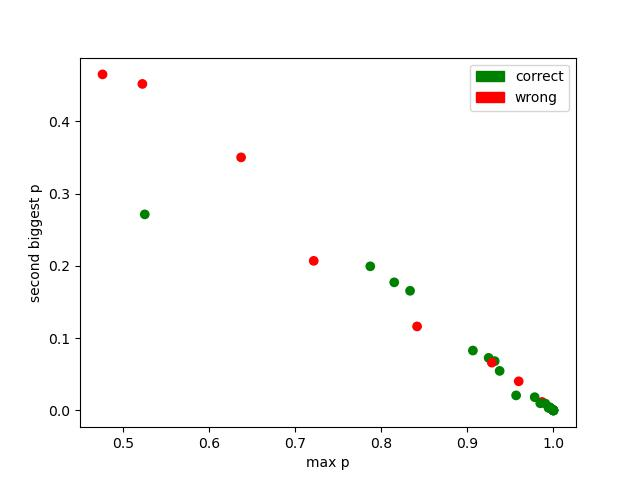

Where the green dots were classified correctly, and the red dots were not.

# Testing

First, we will read the testing features from the csv file, standardize them, and reduce their dimensionality using the features_selection_model we trained on the training dataset:

In [ ]:
features_test = pd.read_csv(songs_features_test_fname, index_col=0, header=[0, 1, 2])
songs_names = get_songs_names(features_test)
X = standardize_features(features_test)

# Features selection
features_selection_model = utils.load(op.join(PROJECT_FOL, 'features_selection_model.pkl'))
X = features_selection_model.transform(X)

Next, we will go over all the classifiers that we trained and saved, and use them to calculate the probabilities for all the songs' buffers in the test dataset. For each classifier, we will calculate the following scores:
* probs_var: measures the uncertainty - low variance means high uncertainty (all the labels get similar probabilities), where high variance means low uncertainty (one high probability and all the rest are small)
* probs_max: measures the certainty - how much the classifier is "sure" about its decision

In [ ]:
models = glob.glob(op.join(models_fol, '*.pkl'))
for model_fname in tqdm(models):
    clf_name = op.basename(model_fname).split('_')[0]
    clf = utils.load(model_fname)
    probs = clf.predict_proba(X)
    probs_var = np.var(probs, axis=1)
    if np.all(probs_var == probs_var[0]):
        continue
    probs_max = np.max(probs, axis=1)
    models_probs_var[clf_name].append(probs_var)
    models_probs_max[clf_name].append(probs_max)

Now, for each classifier, we can average the scores for each classifier. Remember that we trained 10 times using random picking with each classifier. For each classifier, we will present the scores using a scatter plot, where the x axis is the certainty score (max_p), and the y is the uncertainty (var_p):

In [ ]:
for clf_name, model_probs_var in models_probs_var.items():
    score, max_probs_score, var_prob_score, roc_auc_ovo, roc_auc_ovr = calc_mean_scores(all_scores, clf_name)
    # Take only the best classifiers, who gives score * max_probs_score > 0.8
    if score * max_probs_score < 0.8:
        continue

    # Average the scores 
    model_mean_probs_var = np.array(model_probs_var).mean(0)
    model_mean_probs_max = np.array(models_probs_max[clf_name]).mean(0)
    
    songs_probs_max, songs_probs_var = defaultdict(list), defaultdict(list)
    for ind in range(len(songs_names)):
        songs_probs_max[songs_names[ind]].append(model_mean_probs_max[ind])
        songs_probs_var[songs_names[ind]].append(model_mean_probs_var[ind])

    # Averaging the scores for each song (each song can many scores as the number of buffers)
    songs_probs_max_mean = [np.mean(probs) for song_name, probs in songs_probs_max.items()]
    songs_probs_var_mean = [np.mean(probs) for song_name, probs in songs_probs_var.items()]

    # Plot certainty scatter plot (max(p) / var(p)
    plot_certainty_scatter_plot(clf_name, model_mean_probs_max, model_mean_probs_var, figures_fol)

    # Sort the songs according to the certainty (songs_probs_max), from low to high
    # Take a cutoff of 0.85, based on the MLP2 certainty scatter plot
    # This number should be calculated automatically
    songs_scores = sorted([(np.mean(probs), song_name) for song_name, probs in songs_probs_max.items()
                      if (np.mean(probs) < 0.85)])
    print('Classifier: {}'.format(clf_name))
    print(songs_scores)


def plot_certainty_scatter_plot(clf_name, model_mean_probs_max, model_mean_probs_var, figures_fol):
    import matplotlib.pyplot as plt
    plt.figure()
    plt.scatter(model_mean_probs_max, model_mean_probs_var)
    plt.title(clf_name)
    plt.xlabel('max(p)')
    plt.ylabel('var(p)')
    plt.savefig(op.join(figures_fol, '{}.jpg'.format(clf_name)))
    plt.close()

Here is the certainty (max(p) / var(p)) scatter plot using the best classifier - Multi-layer Perceptron (MLP2)

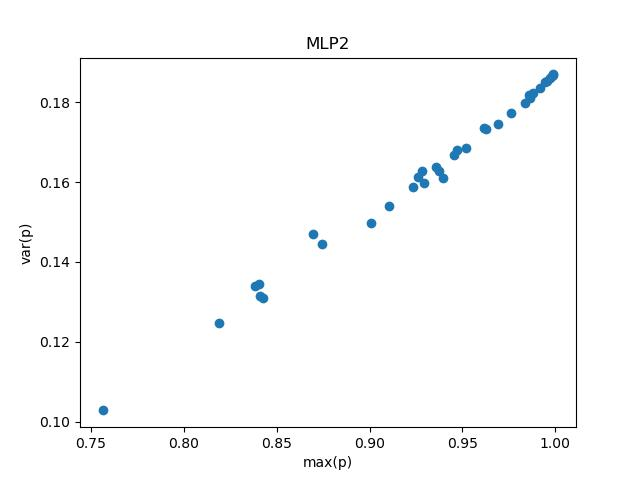

### Choosing the outliers
To choose the outliers songs - songs that weren't composed by any of the composers from the training dataset, we will find the songs with the average lowest certainty (max(p) < 0.85)
Here are the 6 songs with the lowest certainty:

* '0.3559970176888735_adj' (0.756)
* '0.1755252422917658_adj' (0.818) 
* '0.22047111832936942_adj' (0.838)
* '0.7491289879531658_adj' (0.84) 
* '0.337517805339117_adj' (0.84) 
* '0.23120017256495873_adj' (0.84)

## Improvements 
* It's a bit hard to find the exact number of outliers. Also, a different classifier with a bit lower score would give us different results. Therefore, this approach is not very robust. Maybe an ensemble approach would help.
* The two Multi-layer Perceptrons gave the best results, where the hidden_layer_sizes was chosen hard coded. This parameters should be tuned using hyperparameter optimization, like with the rbf and poly SVM models.
* The number of features in the features selection process should be tuned.
* Add more features. For example, use the Spotify APIs.
* Neural network such as Triplet Networks might improve the solution, like in this paper:
https://arxiv.org/abs/2008.04938
